# Real Versus AI-Generated Images
This notebook database is on [CIFAKE: Real and AI-Generated Synthetic Images](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images) by Jordan J. Bird on Kaggle. Can computer vision detect images generated by AI? With the amount of AI generated content on the media, a lot of people may be mistaken or tricked from these generated images. Numerous photography contests have fell in the hands of AI generated images and it has become so hard to figure out what is real and what is fake. Here's a notebook to break down what is CNN and what different models we can try out.

## Convolutional Neural Networks (CNN)
Convolutional neural networks are specialized neural networks used for processing grid-like data, particularly images, using convolutional layers. A typical CNN includes:
* Convolutional layers: apply filters to the input to extract features
* Pooling layers: reduce the spatial dimensions (down-sampling)
* Fully connected layers: perform classification based on the extracted features

Convolutional layers are filters with the mathematical operation to convolute and find features on an image. The output of the convolutional layer on the images is a feature map which is a representation of the input images. These features could be things like corners, shadows, edges, textures, etc. Pooling layers are then used to reduce spatial dimensions on the images, making it easier to process all the images. The right enough pooling will reduce weights that could cause overfitting. There is max pooling and average pooling, two major ways to pool in a network. Fully connected layers are usually used near end of the network which is supposed to take all the features that had been dug out and make meaning to them for predictions and classfication. This layer flattens all the output from previous layers to combine and analyze the features.

Neural networks also deal with something called the activation function which is used to bring in some of that math magic, introducing non-linearity to the model to allow the network to learn some more complex patterns. In this case, we will be using ReLU (Rectified Linear Unit) a very common choice because of how good it works for tasks like this one. Some activation functions are too simple but ReLU is simple yet efficient and does the job without introducing much vanishing gradients (an issue for training).

We'll also deal with lines of code that perform batch normalization amd dropouts. Batch normalization is just a technique that normalizes the input to prevent issues with changes in each layer when training. Dropout is a regularization technique that drops out some neurons to prevent overfitting of the model and forces the model to learn better with what is left of the model.

## Step 0: Exploratory Data Analysis
Let's do some simple analysis of the images we have in the training folder. There are a lot of images and it takes quite a while to load everything so we'll leave it at around 10k images to use as test. In any case if there is issues with how long the code runs, we can perform some principal component analysis (PCA).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

def load_images(folder, n=10000):
    images = []
    for filename in os.listdir(folder)[:n]:
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(np.array(img))
    return images

def display_images(images, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15,5))
    for i in range(n):
        axes[i].imshow(images[i])
        axes[i].axis('off')
    plt.show()

In [2]:
train_fake_dir = 'train/FAKE/'
train_real_dir = 'train/REAL/'
train_fake = load_images(train_fake_dir)
train_real = load_images(train_real_dir)

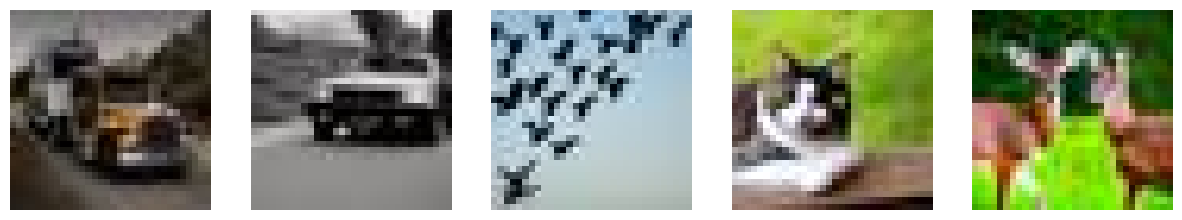

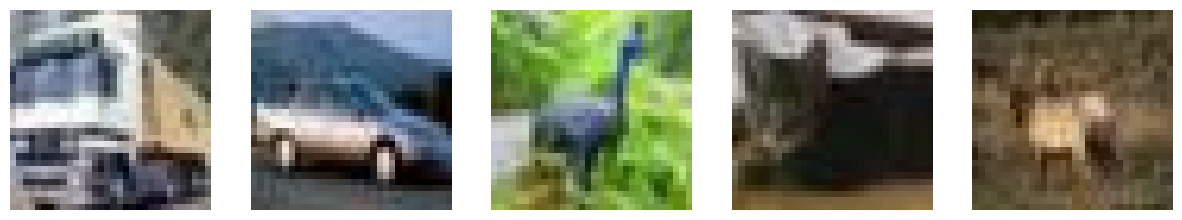

In [3]:
display_images(train_fake)
display_images(train_real)

In [4]:
# Just to check distribution of image sizes
shapes1 = [img.shape for img in train_fake]
shapes2 = [img.shape for img in train_real]

print("Fake images:", np.unique(shapes1, return_counts=True))
print("Real images:", np.unique(shapes2, return_counts=True))
print(np.array(train_fake[0]).shape)
print(np.array(train_real[0]).shape)

Fake images: (array([ 3, 32]), array([10000, 20000], dtype=int64))
Real images: (array([ 3, 32]), array([10000, 20000], dtype=int64))
(32, 32, 3)
(32, 32, 3)


## Step 1: CNN Model
Let's try to create our own CNN model. Might be a naive approach to how a really good CNN might look but instaed of trying things like GoogLeNet, ResNet50, or AlexNet, let's create our own to understand each step of a convolutional neural network and what really each layer does. This is a linear CNN while in other cases certain CNN perform processes with the front and back as well as the sequential process, like one with multi-output. For now, let's keep it simple and break down each step. Using TensorFlow and Keras, we can develop a model that deals with images and convolutional neural networks.

FYI: I'm using TensorFlow just because I'm more used to it but to be honest you could make a CNN with PyTorch as well

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD

def simple_cnn():
    model = models.Sequential()

    # First convolutional block w/ 32 filters
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=l2(0.001))) # ADJUST L2
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3)) # Usually dropout 20-30% I believe

    # Second convolutional block w/ 64 filters
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001))) # ADJUST L2
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3)) # ADJUST DROPOUT

    # Third convolutional block w/ 128
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001))) # ADJUST L2
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3)) # ADJUST DROPOUT

    # Flatten and have fully connected layers
    model.add(layers.Flatten())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001))) # ADJUST L2
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3)) # ADJUST DROPOUT
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))) # ADJUST L2
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3)) # ADJUST DROPOUT

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid')) # Binary classification
    optimizer = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [6]:
cnn_model = simple_cnn()
cnn_model.summary()

C:\Users\noble\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Step 2: Training & Evaluating

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def preprocess_images(images, target_size=(32, 32)):
    processed_images = [Image.fromarray(img).resize(target_size) for img in images]
    processed_images = np.array([np.array(img) for img in processed_images]) / 255.0
    return processed_images

train_fake = preprocess_images(train_fake)
train_real = preprocess_images(train_real)

labels_fake = np.zeros(len(train_fake))  # 0 for fake
labels_real = np.ones(len(train_real))   # 1 for real

x = np.concatenate((train_fake, train_real), axis=0)
y = np.concatenate((labels_fake, labels_real), axis=0)

# Split into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

In [8]:
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # ADJUST PATIENCE

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,   # Smaller rotation
    width_shift_range=0.1,  # Moderate shifts
    height_shift_range=0.1,
    zoom_range=0.1,  # Smaller zoom
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow(x_train, y_train, batch_size=128)
val_generator = val_datagen.flow(x_val, y_val, batch_size=32)

In [10]:
# class_weights = {0: 1.0, 1: 1.0}

history = cnn_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping]
)

Epoch 1/100


C:\Users\noble\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.5783 - loss: 1.4734 - val_accuracy: 0.4952 - val_loss: 1.5726
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/100


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
C:\Users\noble\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.6792 - loss: 1.2812 - val_accuracy: 0.4952 - val_loss: 1.6725
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.7052 - loss: 1.2274 - val_accuracy: 0.4952 - val_loss: 1.7537
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.7100 - loss: 1.2016 - val_accuracy: 0.4952 - val_loss: 1.8286
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.7409 - loss: 1.1596 - val_accuracy: 0.4952 - val_loss: 1.5926
Epoch 10/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.7515 - loss: 1.1445 - va

In [11]:
val_loss, val_accuracy = cnn_model.evaluate(val_generator, steps=len(val_generator))
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8713 - loss: 0.7954
Validation Loss: 0.7868596315383911
Validation Accuracy: 0.8809999823570251


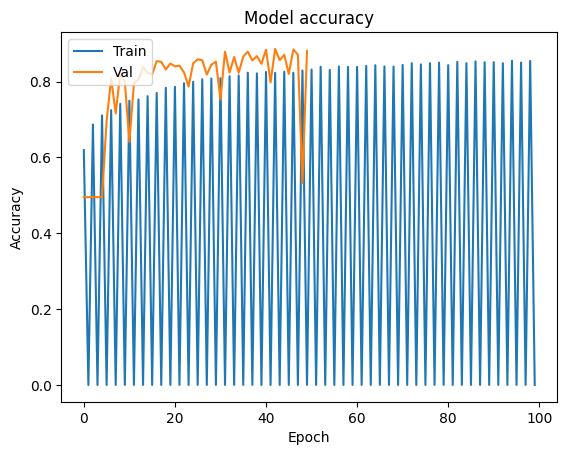

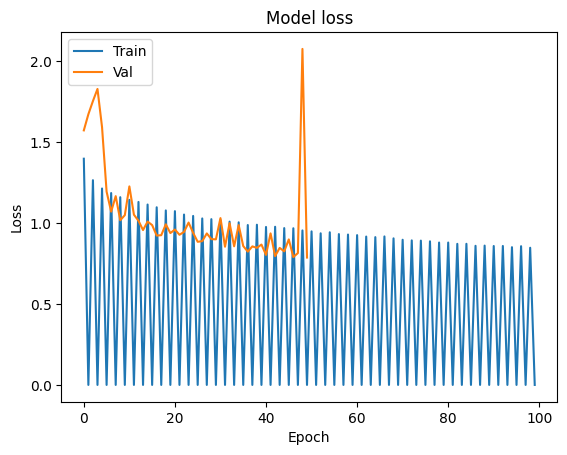

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [13]:
cnn_model.save('model.h5')
loaded_model = tf.keras.models.load_model('model.h5')

Now why is the accuracy so low? There can be many reasons to that. While writing this I am testing out new things and changing the convolution layers as well as how the model is used like changing the early stopping but it is rought to just look at the graph and know what is wrong right away. Here are some thoughts about what could be wrong:
* We overlooked something while preprocessing the images; I would treat that this is unlikely due to the reputation of how good this dataset is on the Kaggle website but you can never discount the possibility since we don't know how the images look
* The model is oversimple; we do only have the default 3x3 filters in the layers and only have three convolutional blocks which might not be enough. The library includes many different ways to build a model and we are not limited to what we have. Increasing the complexity can bring out better results
* Changing around our optimizer, L2 regularization values, epochs, early stopping values, trying class weights

Largest issue is the fluctuating accuracy values which I couldn't seem to make better. Other than that, I was able to increase the accuracy from 55% to 87% which is alright. Let's test it out first and see what we have before we try out transfer learning!

## Step 3: Testing with Predictions